In [52]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import h5py
import numpy as np

from vit_pytorch import ViT

sys.path.append("/home/lord225/pyrepos/explain-rl")

from ppo import PPO
import procgenwrapper

MODEL_PATH = "/home/lord225/pyrepos/explain-rl/preserve"
DATA_PATH = "/home/lord225/pyrepos/explain-rl/explain/records"

MODEL_NAME = "20250402-092247-StopOpenEarly_6_v3.1"

MODEL_PATH = os.path.join(MODEL_PATH, MODEL_NAME)
DATA_PATH = os.path.join(DATA_PATH, MODEL_NAME+"_replay.h5")

venv = procgenwrapper.ProcGenWrapper("starpilot", human=False, collect_seg=True)

model = PPO.load(MODEL_PATH,
                    env=venv, 
                    print_system_info=True,
                    custom_objects={
                        "ViT":ViT,
                    })

dataset = h5py.File(DATA_PATH, "r")

observations = np.array(dataset["observations"])
actions = np.array(dataset["actions"])
rewards = np.array(dataset["rewards"])
dones = np.array(dataset["dones"])
seg_observations = np.array(dataset["seg_observations"])
next_observations = np.array(dataset["next_observations"])

dataset.close() 

print(observations.shape)

net = model.policy
vit = net.mlp_extractor.policy_net[1]
vit


== CURRENT SYSTEM INFO ==
- OS: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39 # 1 SMP Tue Nov 5 00:21:55 UTC 2024
- Python: 3.9.21
- Stable-Baselines3: 2.5.0
- PyTorch: 2.6.0+cu124
- GPU Enabled: True
- Numpy: 1.26.4
- Cloudpickle: 1.2.2
- Gymnasium: 1.0.0
- OpenAI Gym: 0.15.7

== SAVED MODEL SYSTEM INFO ==
- OS: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39 # 1 SMP Tue Nov 5 00:21:55 UTC 2024
- Python: 3.9.21
- Stable-Baselines3: 2.5.0
- PyTorch: 2.6.0+cu124
- GPU Enabled: True
- Numpy: 1.26.4
- Cloudpickle: 1.2.2
- Gymnasium: 1.0.0
- OpenAI Gym: 0.15.7

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
(50000, 64, 64, 9)


ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
    (1): LayerNorm((144,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=144, out_features=64, bias=True)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-3): 4 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.0, inplace=False)
          (to_qkv): Linear(in_features=64, out_features=1152, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=384, out_features=64, bias=True)
            (1): Dropout(p=0.0, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0): Layer

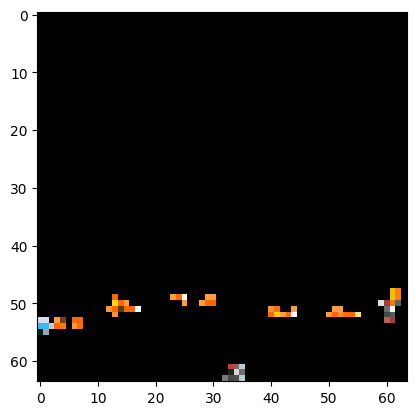

In [53]:
import matplotlib.pyplot as plt

INDEX = 110

plt.imshow(observations[INDEX][:,:,6:])

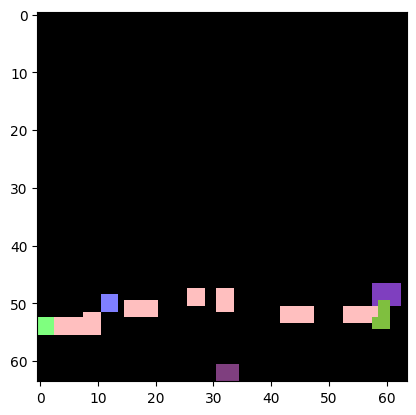

In [54]:
plt.imshow(seg_observations[INDEX][:,:,:])

In [55]:
seg_observations.shape

(50000, 64, 64, 3)

In [56]:
seg_observations.reshape(-1, seg_observations.shape[3]).shape

(204800000, 3)

In [6]:
# # (10000, 64, 64, 3)
# unique_colors = np.unique(seg_observations.reshape(-1, seg_observations.shape[3]), axis=0)
# unique_colors, unique_colors.shape

In [57]:
UNIQUE_COLORS = np.array([[  0,   0,   0],
        [127,  63, 127],
        [127,  63, 191],
        [127, 127, 255],
        [127, 191,  63],
        [127, 255, 127],
        [191, 255, 255],
        [255, 127, 127],
        [255, 191, 191],
        [255, 191, 255]], dtype=np.uint8)[np.newaxis]
UNIQUE_COLORS = np.squeeze(UNIQUE_COLORS, axis=0)
UNIQUE_COLORS.shape

(10, 3)

In [64]:
import tqdm

def segments_to_map(size):
    SIZE = size
    POOLER = nn.AvgPool2d(kernel_size=SIZE, stride=SIZE)

    def s_to_map(segment):
        encoded_segments = np.zeros((64, 64, len(UNIQUE_COLORS)), dtype=np.float32)

        for i in range(len(UNIQUE_COLORS)):
            mono = np.all(segment == UNIQUE_COLORS[i, :], axis=2)
            mono = mono.astype(np.float32)
            encoded_segments[:, :, i] = mono
        # resize to 16x16
        channels = POOLER(th.tensor(encoded_segments).permute(2, 0, 1)).permute(1, 2, 0).numpy()
        return channels


    segmented = []
    for i in tqdm.tqdm(range(seg_observations.shape[0])):
        segmented.append(s_to_map(seg_observations[i]))

    segmented = np.array(segmented)
    return segmented

segmented = segments_to_map(32)

100%|██████████| 50000/50000 [00:53<00:00, 942.14it/s] 


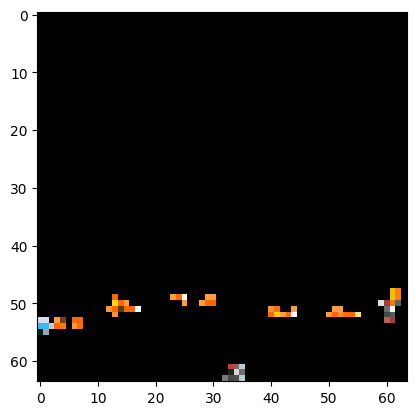

In [65]:
plt.imshow(observations[INDEX][:,:,6:])

In [66]:
segmented.shape

(50000, 2, 2, 10)

In [67]:
segmented[0]

array([[[0.98535156, 0.        , 0.        , 0.        , 0.        ,
         0.01171875, 0.        , 0.        , 0.00292969, 0.        ],
        [1.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ]],

       [[1.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [1.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ]]],
      dtype=float32)

# Figure out what each class means

In [68]:
segmented[0].shape

(2, 2, 10)

In [69]:
# find for each segment class an example of observation, and segment (2x14) plots

# find one sample in segmented dataset where the given segment class is present
def find_segment_class_in_dataset(seg_class):
    if np.sum(segmented[INDEX][:,:,seg_class]) > 0:
        return INDEX
    for i in range(segmented.shape[0]):
        if np.sum(segmented[i][:,:,seg_class]) > 0:
            return i
    return -1

examples = []

for i in range(10):
    index = find_segment_class_in_dataset(i)
    if index != -1:
        examples.append(index)
    else:
        examples.append(-1)

print(examples)

[110, 110, 110, 110, 110, 110, 24, 22, 110, 20]


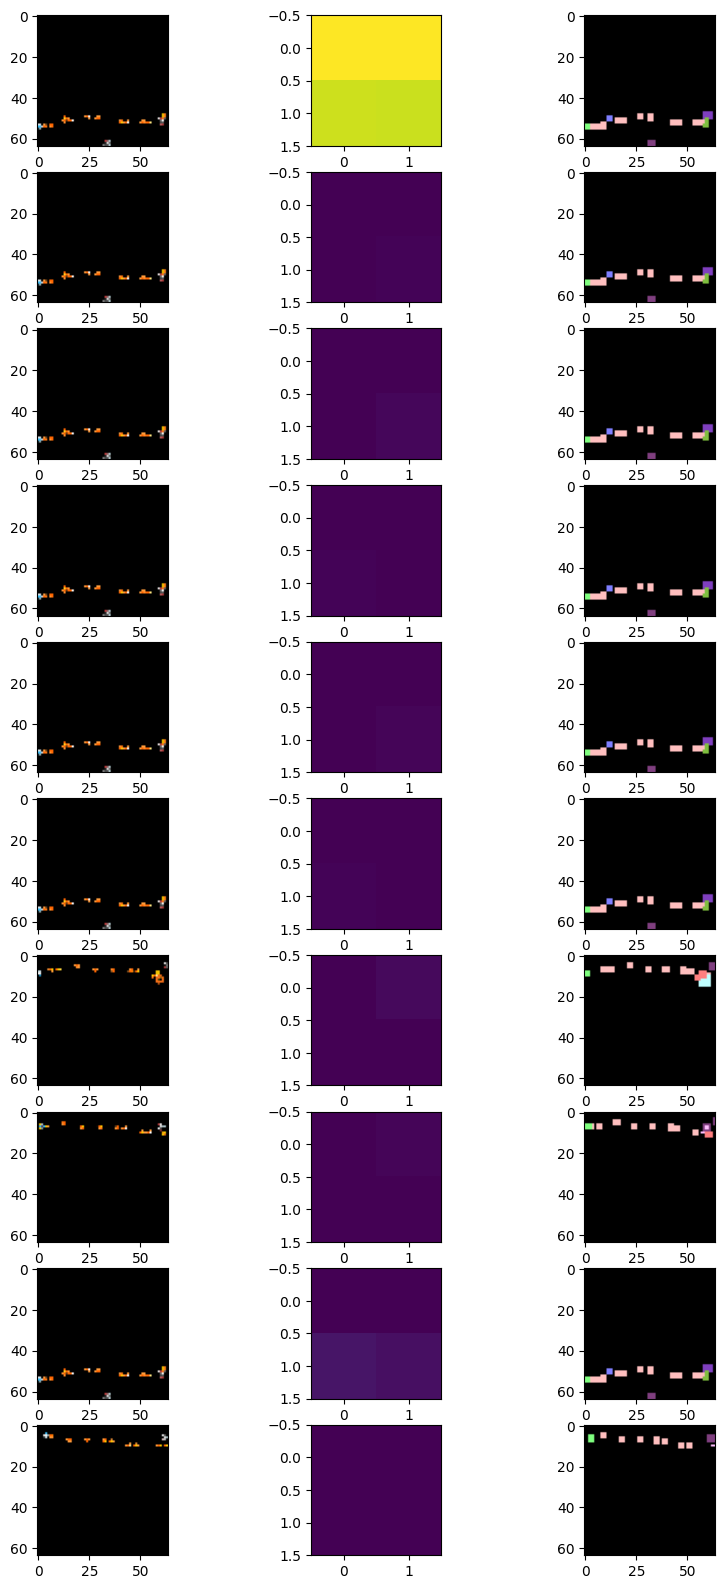

In [70]:
# show examples
fig, axs = plt.subplots(10, 3, figsize=(10, 20))

for i in range(10):
    if examples[i] != -1:
        axs[i, 0].imshow(observations[examples[i]][:,:,6:])
        axs[i, 1].imshow(segmented[examples[i]][:,:,i], vmin=0, vmax=1)
        axs[i, 2].imshow(seg_observations[examples[i]][:,:,:])
    else:
        axs[i, 0].imshow(np.zeros((64, 64, 3), dtype=np.uint8))
        axs[i, 1].imshow(np.zeros((64, 64, 3), dtype=np.uint8))
        axs[i, 2].imshow(np.zeros((64, 64, 3), dtype=np.uint8))

In [71]:
features_names = [
    "bg",
    "enemy",
    "enemy_bullet",
    "enemy2",
    "enemy_fire",
    "player",
    "explosion",
    "enemy_fire",
    "player_bullet",
    "enemy_bullet",
]

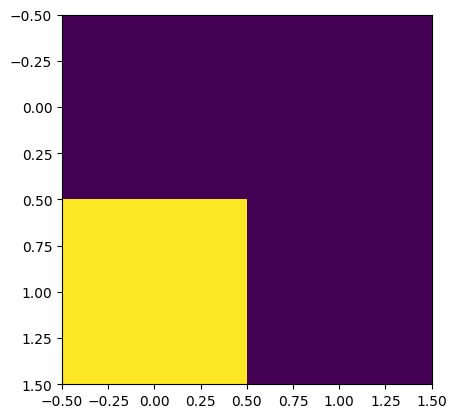

In [72]:
#plt.imshow(segmented[INDEX][:,:,0])
plt.imshow(segmented[INDEX][:,:,5])

In [73]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

In [74]:
actions[0]

9

Wyjaśniać:
Spróbować na subset akcji (na przykład same kierunki)
Albo czy fire
zmneijszyć rozdzielczość po ludzku
Dodać customowe cechy


In [75]:
model = tree.DecisionTreeClassifier(max_leaf_nodes=50, max_depth=5)


X = segmented.reshape(-1, segmented.shape[1]*segmented.shape[2]*segmented.shape[3])
y = actions

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print("Accuracy:", accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))
print("Report Train")
print(classification_report(y_train, y_pred_train))


Accuracy: 0.2307
              precision    recall  f1-score   support

           0       0.20      0.44      0.27      1452
           1       0.00      0.00      0.00       155
           2       0.39      0.73      0.51      1170
           3       0.00      0.00      0.00       653
           4       0.00      0.00      0.00        96
           5       0.00      0.00      0.00       304
           6       0.00      0.00      0.00        79
           7       0.00      0.00      0.00        39
           8       0.00      0.00      0.00        80
           9       0.19      0.39      0.26      1570
          10       0.00      0.00      0.00        53
          11       0.12      0.00      0.00      1267
          12       0.15      0.17      0.16      1188
          13       0.00      0.00      0.00       792
          14       0.00      0.00      0.00      1102

    accuracy                           0.23     10000
   macro avg       0.07      0.12      0.08     10000
weighted 

/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [78]:
data = []
for i in [2,4,6,8,16,32,64]:
    print("i", i)
    segmented = segments_to_map(i)
    X = segmented.reshape(-1, segmented.shape[1]*segmented.shape[2]*segmented.shape[3])
    y = actions

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = tree.DecisionTreeClassifier(max_depth=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print("Accuracy:", accuracy_score(y_test, y_pred))

    print(classification_report(y_test, y_pred))
    data.append((i, classification_report(y_test, y_pred, output_dict=True)))

print(data)

i 2


100%|██████████| 50000/50000 [00:54<00:00, 920.93it/s] 
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

Accuracy: 0.1835
              precision    recall  f1-score   support

           0       0.59      0.13      0.22      1452
           1       0.00      0.00      0.00       155
           2       0.29      0.03      0.05      1170
           3       0.00      0.00      0.00       653
           4       0.00      0.00      0.00        96
           5       0.35      0.05      0.08       304
           6       0.45      0.06      0.11        79
           7       0.44      0.10      0.17        39
           8       0.86      0.07      0.14        80
           9       0.16      0.92      0.27      1570
          10       0.00      0.00      0.00        53
          11       0.23      0.01      0.02      1267
          12       0.24      0.10      0.14      1188
          13       0.00      0.00      0.00       792
          14       0.38      0.01      0.01      1102

    accuracy                           0.18     10000
   macro avg       0.27      0.10      0.08     10000
weighted 

100%|██████████| 50000/50000 [00:53<00:00, 936.42it/s] 
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

Accuracy: 0.2108
              precision    recall  f1-score   support

           0       0.20      1.00      0.33      1452
           1       0.00      0.00      0.00       155
           2       0.00      0.00      0.00      1170
           3       0.00      0.00      0.00       653
           4       0.00      0.00      0.00        96
           5       0.00      0.00      0.00       304
           6       0.00      0.00      0.00        79
           7       0.00      0.00      0.00        39
           8       0.00      0.00      0.00        80
           9       0.25      0.40      0.31      1570
          10       0.00      0.00      0.00        53
          11       0.36      0.00      0.01      1267
          12       0.23      0.01      0.02      1188
          13       0.00      0.00      0.00       792
          14       0.21      0.02      0.03      1102

    accuracy                           0.21     10000
   macro avg       0.08      0.10      0.05     10000
weighted 

100%|██████████| 50000/50000 [00:53<00:00, 938.39it/s] 
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

Accuracy: 0.2039
              precision    recall  f1-score   support

           0       0.19      0.99      0.32      1452
           1       0.00      0.00      0.00       155
           2       0.00      0.00      0.00      1170
           3       0.24      0.01      0.01       653
           4       0.00      0.00      0.00        96
           5       0.00      0.00      0.00       304
           6       0.00      0.00      0.00        79
           7       0.00      0.00      0.00        39
           8       0.00      0.00      0.00        80
           9       0.25      0.35      0.29      1570
          10       0.00      0.00      0.00        53
          11       0.10      0.00      0.00      1267
          12       0.24      0.02      0.03      1188
          13       0.00      0.00      0.00       792
          14       0.25      0.03      0.06      1102

    accuracy                           0.20     10000
   macro avg       0.08      0.09      0.05     10000
weighted 

100%|██████████| 50000/50000 [00:50<00:00, 993.97it/s] 
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

Accuracy: 0.2073
              precision    recall  f1-score   support

           0       0.21      0.32      0.25      1452
           1       0.00      0.00      0.00       155
           2       0.20      0.84      0.32      1170
           3       0.00      0.00      0.00       653
           4       0.00      0.00      0.00        96
           5       0.00      0.00      0.00       304
           6       0.00      0.00      0.00        79
           7       0.00      0.00      0.00        39
           8       0.00      0.00      0.00        80
           9       0.23      0.37      0.28      1570
          10       0.00      0.00      0.00        53
          11       0.50      0.00      0.00      1267
          12       0.21      0.04      0.06      1188
          13       0.00      0.00      0.00       792
          14       0.50      0.00      0.00      1102

    accuracy                           0.21     10000
   macro avg       0.12      0.10      0.06     10000
weighted 

100%|██████████| 50000/50000 [00:53<00:00, 939.69it/s] 
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

Accuracy: 0.2267
              precision    recall  f1-score   support

           0       0.18      0.76      0.30      1452
           1       0.00      0.00      0.00       155
           2       0.42      0.57      0.49      1170
           3       0.00      0.00      0.00       653
           4       0.00      0.00      0.00        96
           5       0.00      0.00      0.00       304
           6       0.00      0.00      0.00        79
           7       0.00      0.00      0.00        39
           8       0.00      0.00      0.00        80
           9       0.22      0.24      0.23      1570
          10       0.00      0.00      0.00        53
          11       0.16      0.07      0.10      1267
          12       0.16      0.03      0.06      1188
          13       0.00      0.00      0.00       792
          14       0.12      0.00      0.00      1102

    accuracy                           0.23     10000
   macro avg       0.09      0.11      0.08     10000
weighted 

100%|██████████| 50000/50000 [00:50<00:00, 993.99it/s] 
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

Accuracy: 0.2307
              precision    recall  f1-score   support

           0       0.20      0.44      0.27      1452
           1       0.00      0.00      0.00       155
           2       0.39      0.73      0.51      1170
           3       0.00      0.00      0.00       653
           4       0.00      0.00      0.00        96
           5       0.00      0.00      0.00       304
           6       0.00      0.00      0.00        79
           7       0.00      0.00      0.00        39
           8       0.00      0.00      0.00        80
           9       0.19      0.39      0.26      1570
          10       0.00      0.00      0.00        53
          11       0.12      0.00      0.00      1267
          12       0.15      0.17      0.16      1188
          13       0.00      0.00      0.00       792
          14       0.00      0.00      0.00      1102

    accuracy                           0.23     10000
   macro avg       0.07      0.12      0.08     10000
weighted 

100%|██████████| 50000/50000 [00:49<00:00, 1005.26it/s]


Accuracy: 0.224
              precision    recall  f1-score   support

           0       0.19      0.32      0.24      1452
           1       0.00      0.00      0.00       155
           2       0.42      0.68      0.52      1170
           3       0.00      0.00      0.00       653
           4       0.00      0.00      0.00        96
           5       0.00      0.00      0.00       304
           6       0.00      0.00      0.00        79
           7       0.00      0.00      0.00        39
           8       0.00      0.00      0.00        80
           9       0.17      0.61      0.27      1570
          10       0.00      0.00      0.00        53
          11       0.26      0.02      0.03      1267
          12       0.09      0.00      0.00      1188
          13       0.00      0.00      0.00       792
          14       0.00      0.00      0.00      1102

    accuracy                           0.22     10000
   macro avg       0.08      0.11      0.07     10000
weighted a

/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

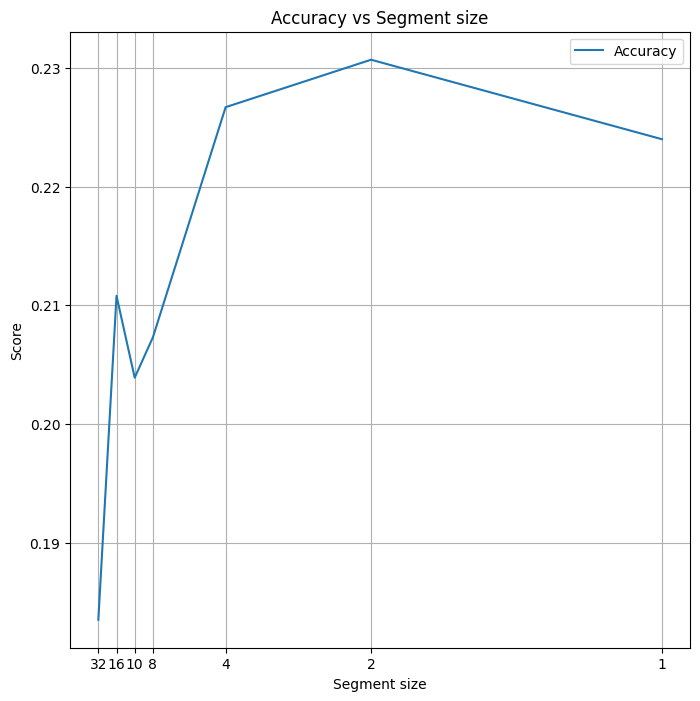

In [96]:
plt.figure(figsize=(8, 8))
plt.plot([d[0] for d in data], [d[1]['accuracy'] for d in data], label="Accuracy")
plt.xticks([d[0] for d in data], [str(64//d[0]) for d in data])
plt.xlabel("Segment size")
plt.ylabel("Score")
plt.grid()
plt.title("Accuracy vs Segment size")
plt.legend()

In [21]:
# check leaf nodes vs test-f1 score
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import tqdm
from joblib import Parallel, delayed

def train_model(model, X_train, y_train, X_test, y_test):
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    return f1_score(y_test, y_pred, average='macro'), f1_score(y_train, y_pred_train, average='macro')

leaf_nodes = tqdm.trange(10, 1000, 1)

from joblib import parallel_backend

with parallel_backend('loky'): 
    f1_scores = list(tqdm.tqdm(
        Parallel(n_jobs=-1)(
            delayed(train_model)(tree.DecisionTreeClassifier(max_leaf_nodes=i), X_train, y_train, X_test, y_test)
            for i in leaf_nodes
        ),
        total=len(leaf_nodes)
    ))

100%|██████████| 990/990 [00:00<00:00, 4352579.62it/s]


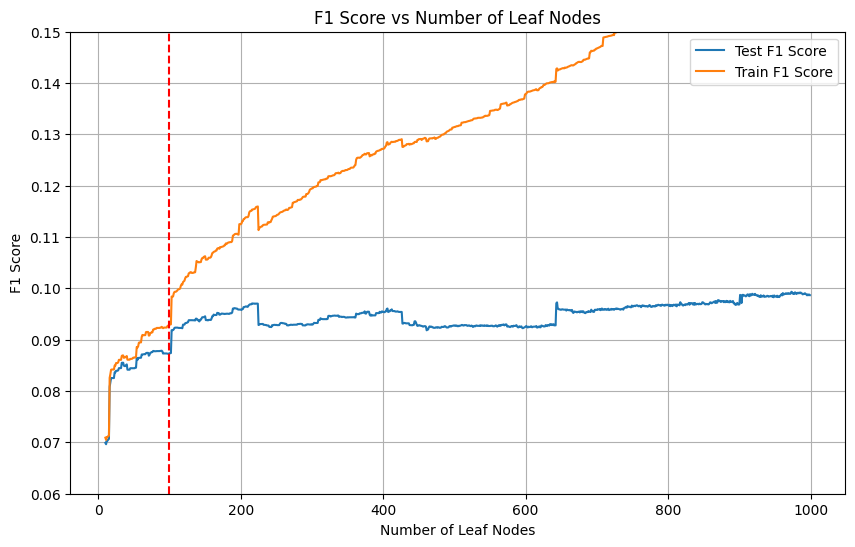

In [22]:
# Extract F1 scores for test and train
f1_scores_test = [score[0] for score in f1_scores]
f1_scores_train = [score[1] for score in f1_scores]

# Plot the F1 scores
plt.figure(figsize=(10, 6))
plt.plot(range(10, 1000, 1), f1_scores_test, label='Test F1 Score')
plt.plot(range(10, 1000, 1), f1_scores_train, label='Train F1 Score')

# Add labels, title, and legend
plt.xlabel('Number of Leaf Nodes')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Number of Leaf Nodes')
plt.legend()
plt.ylim(0.06, 0.15)
plt.axvline(x=100, color='r', linestyle='--')
plt.grid()
plt.show()

In [25]:
x = GridSearchCV(
    estimator=model,
    param_grid={
        "max_leaf_nodes": [10, 20, 30, 40, 50, 100, 200, 300, 400, 500],
        "max_depth": [2, 3, 5, 10, 20],
        "min_samples_leaf": [1, 2, 3],
        "min_samples_split": [2, 3, 4, 5],
    },
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring="f1_macro"
)

x.fit(X_train, y_train)

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(max_depth=5, max_leaf_nodes=50),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'max_leaf_nodes': [10, 20, 30, 40, 50, 100, 200, 300,
                                            400, 500],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4, 5]},
             scoring='f1_macro', verbose=1)

In [26]:
import pandas as pd

params = pd.DataFrame(x.cv_results_)
params.sort_values(by="rank_test_score", ascending=True, inplace=True)
params = params[["params", "mean_test_score", "rank_test_score"]]
params

,params,mean_test_score,rank_test_score
598,"{'max_depth': 20, 'max_leaf_nodes': 500, 'min_...",0.098910,1
595,"{'max_depth': 20, 'max_leaf_nodes': 500, 'min_...",0.098804,2
596,"{'max_depth': 20, 'max_leaf_nodes': 500, 'min_...",0.098770,3
588,"{'max_depth': 20, 'max_leaf_nodes': 500, 'min_...",0.098655,4
589,"{'max_depth': 20, 'max_leaf_nodes': 500, 'min_...",0.098521,5
...,...,...,...
86,"{'max_depth': 2, 'max_leaf_nodes': 300, 'min_s...",0.053571,481
87,"{'max_depth': 2, 'max_leaf_nodes': 300, 'min_s...",0.053571,481
88,"{'max_depth': 2, 'max_leaf_nodes': 300, 'min_s...",0.053571,481
60,"{'max_depth': 2, 'max_leaf_nodes': 100, 'min_s...",0.053571,481


In [27]:
x = GridSearchCV(
    estimator=model,
    param_grid={
        "max_leaf_nodes": [80, 90, 100, 110, 120, 150],
        "max_depth": [15, 20, 30, 40],
        "min_samples_leaf": [2],
        "min_samples_split": [3, 4, 5, 10, 15],
    },
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring="f1_macro"
)

x.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, max_leaf_nodes=50),
             n_jobs=-1,
             param_grid={'max_depth': [15, 20, 30, 40],
                         'max_leaf_nodes': [80, 90, 100, 110, 120, 150],
                         'min_samples_leaf': [2],
                         'min_samples_split': [3, 4, 5, 10, 15]},
             scoring='f1_macro', verbose=1)

In [28]:

params = pd.DataFrame(x.cv_results_)
params.sort_values(by="rank_test_score", ascending=True, inplace=True)
params = params[["params", "mean_test_score", "rank_test_score"]]
params

,params,mean_test_score,rank_test_score
89,"{'max_depth': 30, 'max_leaf_nodes': 150, 'min_...",0.091332,1
59,"{'max_depth': 20, 'max_leaf_nodes': 150, 'min_...",0.091329,2
119,"{'max_depth': 40, 'max_leaf_nodes': 150, 'min_...",0.091302,3
27,"{'max_depth': 15, 'max_leaf_nodes': 150, 'min_...",0.091208,4
25,"{'max_depth': 15, 'max_leaf_nodes': 150, 'min_...",0.091181,5
...,...,...,...
33,"{'max_depth': 20, 'max_leaf_nodes': 80, 'min_s...",0.086886,106
31,"{'max_depth': 20, 'max_leaf_nodes': 80, 'min_s...",0.086886,106
30,"{'max_depth': 20, 'max_leaf_nodes': 80, 'min_s...",0.086886,106
94,"{'max_depth': 40, 'max_leaf_nodes': 80, 'min_s...",0.086886,106


In [31]:
x = GridSearchCV(
    estimator=model,
    param_grid={
        "max_leaf_nodes": range(1, 100, 10),
        "max_depth": [2,3,4],
        "min_samples_leaf": range(1, 20, 3),
        "min_samples_split": range(1, 20, 3),
    },
    cv=3,
    n_jobs=-1,
    verbose=1,
    scoring="f1_macro"
)

x.fit(X_train, y_train)

Fitting 3 folds for each of 1470 candidates, totalling 4410 fits


/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1008 fits failed out of a total of 4410.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
441 fits failed with the following error:
Traceback (most recent call last):
  File "/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py", line 436, in _validate_params
    valida

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(max_depth=5, max_leaf_nodes=50),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4],
                         'max_leaf_nodes': range(1, 100, 10),
                         'min_samples_leaf': range(1, 20, 3),
                         'min_samples_split': range(1, 20, 3)},
             scoring='f1_macro', verbose=1)

In [32]:
params = pd.DataFrame(x.cv_results_)
params.sort_values(by="rank_test_score", ascending=True, inplace=True)
params = params[["params", "mean_test_score", "rank_test_score"]]
params

,params,mean_test_score,rank_test_score
1053,"{'max_depth': 4, 'max_leaf_nodes': 11, 'min_sa...",0.077541,1
1038,"{'max_depth': 4, 'max_leaf_nodes': 11, 'min_sa...",0.077541,1
1051,"{'max_depth': 4, 'max_leaf_nodes': 11, 'min_sa...",0.077541,1
1040,"{'max_depth': 4, 'max_leaf_nodes': 11, 'min_sa...",0.077541,1
1041,"{'max_depth': 4, 'max_leaf_nodes': 11, 'min_sa...",0.077541,1
...,...,...,...
917,"{'max_depth': 3, 'max_leaf_nodes': 81, 'min_sa...",NaN,1135
427,"{'max_depth': 2, 'max_leaf_nodes': 81, 'min_sa...",NaN,1135
1183,"{'max_depth': 4, 'max_leaf_nodes': 41, 'min_sa...",NaN,1135
910,"{'max_depth': 3, 'max_leaf_nodes': 81, 'min_sa...",NaN,1135


In [33]:
# train on whole dataset (train)
best_params = params.iloc[0]["params"]
best_model = tree.DecisionTreeClassifier(**best_params)

best_model = best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

print("Report Test")
print(classification_report(y_test, y_pred))
print("Report Train")
print(classification_report(y_train, y_pred_train))


Report Test
              precision    recall  f1-score   support

           0       0.20      0.42      0.27      1452
           1       0.00      0.00      0.00       155
           2       0.45      0.59      0.51      1170
           3       0.00      0.00      0.00       653
           4       0.00      0.00      0.00        96
           5       0.00      0.00      0.00       304
           6       0.00      0.00      0.00        79
           7       0.00      0.00      0.00        39
           8       0.00      0.00      0.00        80
           9       0.17      0.58      0.26      1570
          10       0.00      0.00      0.00        53
          11       0.00      0.00      0.00      1267
          12       0.00      0.00      0.00      1188
          13       0.00      0.00      0.00       792
          14       0.00      0.00      0.00      1102

    accuracy                           0.22     10000
   macro avg       0.05      0.11      0.07     10000
weighted avg  

/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [34]:
actions = np.array(actions)

# [4] NOOP
# [5] UP
# [3] DOWN
# [1] LEFT
# [7] RIGHT
# [11] FIRE
# [12] FIRE
# [10] FIRE BACK
# [9]  FIRE 
# other ignored

# collapes actions into 5 classes (UP, DOWN, LEFT, RIGHT, [FIRE, FIRE BACK])
action_map = {
    0: 4,
    1: 1,
    2: 4,
    3: 3,
    4: 4,
    5: 5,
    6: 4,
    7: 7,
    8: 4,
    9: 9,
    10: 9,
    11: 9,
    12: 9,
    13: 4,
    14: 4,
}

actions_maped = np.zeros(actions.shape, dtype=np.int32)
for i in range(len(actions)):
    actions_maped[i] = action_map[actions[i]]

# filter noop actions
actions_filted = actions_maped[actions_maped != 4]
segmented_filtred = segmented[actions_maped != 4]

In [35]:
actions_filted

array([9, 5, 9, ..., 9, 9, 9], dtype=int32)

In [36]:
# train tree now
model = tree.DecisionTreeClassifier(max_leaf_nodes=50, max_depth=5)

X = segmented_filtred.reshape(-1, segmented_filtred.shape[1]*segmented_filtred.shape[2]*segmented_filtred.shape[3])
y = actions_filted
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Report Train")
print(classification_report(y_train, y_pred_train))

/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.7898343803540834
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       154
           3       0.33      0.00      0.00       632
           5       0.39      0.09      0.14       297
           7       0.00      0.00      0.00        32
           9       0.80      1.00      0.88      4138

    accuracy                           0.79      5253
   macro avg       0.30      0.22      0.21      5253
weighted avg       0.69      0.79      0.71      5253

Report Train
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       646
           3       0.88      0.01      0.01      2537
           5       0.44      0.10      0.16      1122
           7       1.00      0.01      0.01       168
           9       0.79      1.00      0.88     16539

    accuracy                           0.79     21012
   macro avg       0.62      0.22      0.21     21012
weighted avg       0.76      0.79  

/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [37]:
leaf_nodes = tqdm.trange(10, 1000, 1)

from joblib import parallel_backend

with parallel_backend('loky'): 
    f1_scores = list(tqdm.tqdm(
        Parallel(n_jobs=-1)(
            delayed(train_model)(tree.DecisionTreeClassifier(max_leaf_nodes=i), X_train, y_train, X_test, y_test)
            for i in leaf_nodes
        ),
        total=len(leaf_nodes)
    ))

100%|██████████| 990/990 [00:00<00:00, 5262814.90it/s]


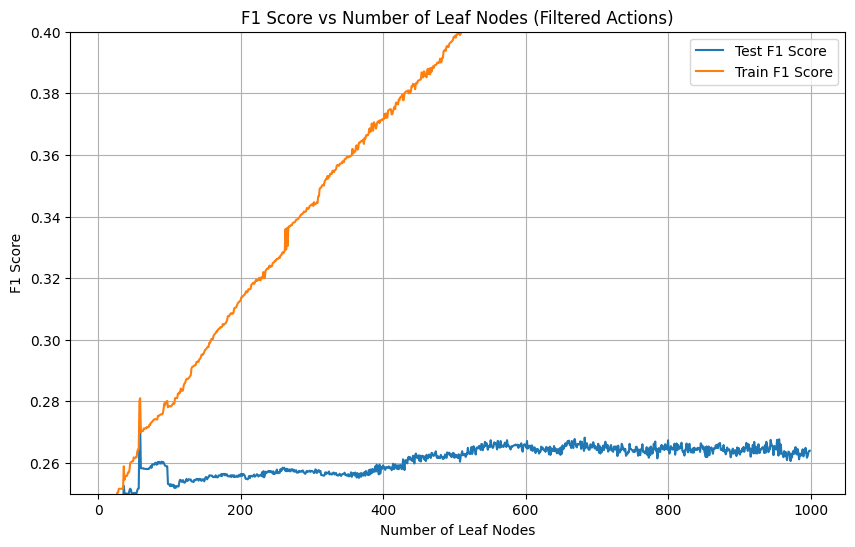

In [38]:
# Extract F1 scores for test and train
f1_scores_test = [score[0] for score in f1_scores]
f1_scores_train = [score[1] for score in f1_scores]

# Plot the F1 scores
plt.figure(figsize=(10, 6))
plt.plot(range(10, 1000, 1), f1_scores_test, label='Test F1 Score')
plt.plot(range(10, 1000, 1), f1_scores_train, label='Train F1 Score')

# Add labels, title, and legend
plt.xlabel('Number of Leaf Nodes')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Number of Leaf Nodes (Filtered Actions)')
plt.legend()
plt.ylim(0.25, 0.4)
plt.grid()
plt.show()

In [39]:
x = GridSearchCV(
    estimator=model,
    param_grid={
        "max_leaf_nodes": range(10, 100, 10),
        "max_depth": [2, 3, 4, 5],
        "min_samples_leaf": range(1, 50, 5),
        "min_samples_split": range(1, 50, 5),
    },
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring="f1_macro"
)

x.fit(X_train, y_train)

Fitting 5 folds for each of 3600 candidates, totalling 18000 fits


/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1800 fits failed out of a total of 18000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1800 fits failed with the following error:
Traceback (most recent call last):
  File "/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py", line 436, in _validate_params
    vali

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, max_leaf_nodes=50),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5],
                         'max_leaf_nodes': range(10, 100, 10),
                         'min_samples_leaf': range(1, 50, 5),
                         'min_samples_split': range(1, 50, 5)},
             scoring='f1_macro', verbose=1)

In [40]:
params = pd.DataFrame(x.cv_results_)
params.sort_values(by=["rank_test_score", "param_max_leaf_nodes"], ascending=[True, True], inplace=True)
params = params[["params", "mean_test_score", "rank_test_score"]]
params

,params,mean_test_score,rank_test_score
2901,"{'max_depth': 5, 'max_leaf_nodes': 30, 'min_sa...",0.212569,1
2902,"{'max_depth': 5, 'max_leaf_nodes': 30, 'min_sa...",0.212555,2
3001,"{'max_depth': 5, 'max_leaf_nodes': 40, 'min_sa...",0.212553,3
3102,"{'max_depth': 5, 'max_leaf_nodes': 50, 'min_sa...",0.212553,3
3401,"{'max_depth': 5, 'max_leaf_nodes': 80, 'min_sa...",0.212547,5
...,...,...,...
3550,"{'max_depth': 5, 'max_leaf_nodes': 90, 'min_sa...",NaN,3241
3560,"{'max_depth': 5, 'max_leaf_nodes': 90, 'min_sa...",NaN,3241
3570,"{'max_depth': 5, 'max_leaf_nodes': 90, 'min_sa...",NaN,3241
3580,"{'max_depth': 5, 'max_leaf_nodes': 90, 'min_sa...",NaN,3241


In [41]:
# train on whole dataset (train)
# best_params = params.iloc[0]["params"]
best_model = tree.DecisionTreeClassifier(max_depth=5, max_leaf_nodes=40, min_samples_split=11)
best_model = best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

y_pred_train = best_model.predict(X_train)
print("Report Test")
print(classification_report(y_test, y_pred))
print("Report Train")
print(classification_report(y_train, y_pred_train))

Report Test
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       154
           3       0.33      0.00      0.00       632
           5       0.39      0.09      0.14       297
           7       0.00      0.00      0.00        32
           9       0.80      1.00      0.88      4138

    accuracy                           0.79      5253
   macro avg       0.30      0.22      0.21      5253
weighted avg       0.69      0.79      0.71      5253

Report Train
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       646
           3       0.88      0.01      0.01      2537
           5       0.44      0.10      0.16      1122
           7       1.00      0.01      0.01       168
           9       0.79      1.00      0.88     16539

    accuracy                           0.79     21012
   macro avg       0.62      0.22      0.21     21012
weighted avg       0.76      0.79      0.71     2101

/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [42]:
features_names, len(features_names)

(['bg',
  'enemy',
  'enemy_bullet',
  'enemy2',
  'enemy_fire',
  'player',
  'explosion',
  'enemy_fire',
  'player_bullet',
  'enemy_bullet'],
 10)

In [43]:
X.shape

(26265, 40)

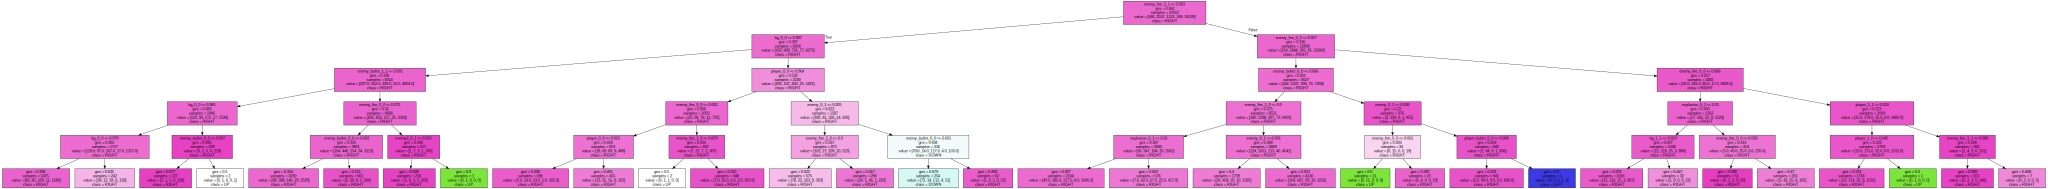

In [44]:
# visualize tree
import matplotlib.pyplot as plt

import graphviz


def get100(name):
    return [
        f"{name}_{i}_{j}" for i in range(2) for j in range(2)
    ]

features_names_all = [get100(features_names[i]) for i in range(len(features_names))]
features_names_all = np.array(features_names_all).flatten()
target_names = ["NOOP", "UP", "DOWN", "LEFT", "RIGHT", "FIRE"]
# DOT data
dot_data = tree.export_graphviz(best_model, out_file=None,
                                class_names=target_names,
                                feature_names=features_names_all,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, filename=None, format="png")
graph

In [45]:
# feature importance
importances = best_model.feature_importances_
print(len(importances))
indices = np.where(np.array(best_model.feature_importances_) > 0)[0]
importances = importances[indices]
features_names_important = features_names_all[indices]
print(features_names_important)

40
['bg_0_0' 'bg_1_1' 'enemy_0_1' 'enemy_bullet_0_0' 'enemy_bullet_1_1'
 'enemy2_0_1' 'enemy_fire_1_0' 'player_0_0' 'player_1_0' 'player_1_1'
 'explosion_0_1' 'enemy_fire_0_0' 'enemy_fire_1_0' 'enemy_fire_1_1'
 'player_bullet_0_0']


Text(0.5, 1.0, 'Feature Importance')

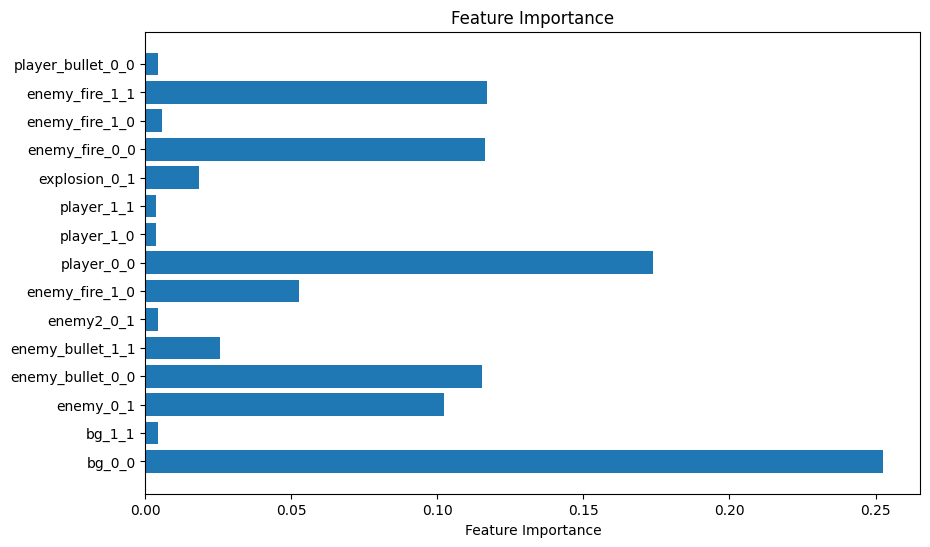

In [46]:
# plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), features_names_important)
plt.xlabel('Feature Importance')
plt.title('Feature Importance')


In [47]:
actions = np.array(actions)

# [4] NOOP
# [5] UP
# [3] DOWN
# [1] LEFT
# [7] RIGHT
# [11] FIRE
# [12] FIRE
# [10] FIRE BACK
# [9]  FIRE 
# other ignored

# collapes actions into 5 classes (UP, DOWN, LEFT, RIGHT, [FIRE, FIRE BACK])
# action_map = {
#     0: 4,
#     1: 1,
#     2: 4,
#     3: 3,
#     4: 4,
#     5: 5,
#     6: 4,
#     7: 7,
#     8: 4,
#     9: 9,
#     10: 9,
#     11: 9,
#     12: 9,
#     13: 4,
#     14: 4,
# }

# actions_maped = np.zeros(actions.shape, dtype=np.int32)
# for i in range(len(actions)):
#     actions_maped[i] = action_map[actions[i]]

# # filter noop actions
# actions_filted = actions_maped[actions_maped != 4]
# segmented_filtred = segmented[actions_maped != 4]

# lets train 3 models: UP/DOWN LEFT/RIGHT and FIRE

# UP/DOWN NONE dataset

action_map = {
    0: 4,
    1: 4,
    2: 4,
    3: 3,
    4: 4,
    5: 5,
    6: 4,
    7: 4,
    8: 4,
    9: 4,
    10: 4,
    11: 4,
    12: 4,
    13: 4,
    14: 4,
}
actions_maped = np.zeros(actions.shape, dtype=np.int32)
for i in range(len(actions)):
    actions_maped[i] = action_map[actions[i]]

X_up_down = segmented.reshape(-1, segmented.shape[1]*segmented.shape[2]*segmented.shape[3])
y_up_down = actions_maped
# weight so that all classes are equal
unique_classes = np.unique(y_up_down, return_counts=True)
# calculate balance weights
from sklearn.utils.class_weight import compute_class_weight
class_weights_up_down = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_up_down = {
    3: class_weights_up_down[0],
    4: class_weights_up_down[1]/2,
    5: class_weights_up_down[2],
}
print(class_weights_up_down)
print(class_weights_up_down)

# LEFT/RIGHT NONE dataset
action_map = {
    0: 4,
    1: 1,
    2: 4,
    3: 4,
    4: 4,
    5: 5,
    6: 4,
    7: 7,
    8: 4,
    9: 4,
    10: 4,
    11: 4,
    12: 4,
    13: 4,
    14: 4,
}

actions_maped = np.zeros(actions.shape, dtype=np.int32)
for i in range(len(actions)):
    actions_maped[i] = action_map[actions[i]]
actions_filted = actions_maped[actions_maped != 4]
segmented_filtred = segmented[actions_maped != 4]

X_left_right = segmented_filtred.reshape(-1, segmented_filtred.shape[1]*segmented_filtred.shape[2]*segmented_filtred.shape[3])
y_left_right = actions_filted

# weight so that all classes are equal
unique_classes = np.unique(y_left_right, return_counts=True)
# calculate balance weights
from sklearn.utils.class_weight import compute_class_weight
class_weights_left_right = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)



# FIRE NONE dataset
action_map = {
    0: 4,
    1: 4,
    2: 4,
    3: 4,
    4: 4,
    5: 4,
    6: 4,
    7: 4,
    8: 4,
    9: 9,
    10: 9,
    11: 9,
    12: 9,
    13: 4,
    14: 4,
}
actions_maped = np.zeros(actions.shape, dtype=np.int32)
for i in range(len(actions)):
    actions_maped[i] = action_map[actions[i]]

actions_filted = actions_maped[actions_maped != 4]
segmented_filtred = segmented[actions_maped != 4]
X_fire = segmented_filtred.reshape(-1, segmented_filtred.shape[1]*segmented_filtred.shape[2]*segmented_filtred.shape[3])
y_fire = actions_filted

{3: 6.505263157894737, 4: 0.8282223098147419, 5: 3.7454545454545456}
{3: 6.505263157894737, 4: 0.8282223098147419, 5: 3.7454545454545456}


In [48]:
model = tree.DecisionTreeClassifier(
    class_weight=class_weights_up_down
)

x = GridSearchCV(
    estimator=model,
    param_grid={
        "max_leaf_nodes": range(2, 100, 1),
        "max_depth": [2, 3, 4, 5, 6],
    },
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring="f1_macro"
)

x.fit(X_up_down, y_up_down)
params = pd.DataFrame(x.cv_results_)
params.sort_values(by=["rank_test_score", "param_max_leaf_nodes"], ascending=[True, True], inplace=True)
params = params[["params", "mean_test_score", "rank_test_score"]]
params

Fitting 5 folds for each of 490 candidates, totalling 2450 fits


,params,mean_test_score,rank_test_score
412,"{'max_depth': 6, 'max_leaf_nodes': 22}",0.350222,1
413,"{'max_depth': 6, 'max_leaf_nodes': 23}",0.350134,2
406,"{'max_depth': 6, 'max_leaf_nodes': 16}",0.350103,3
407,"{'max_depth': 6, 'max_leaf_nodes': 17}",0.350103,3
408,"{'max_depth': 6, 'max_leaf_nodes': 18}",0.350070,5
...,...,...,...
93,"{'max_depth': 2, 'max_leaf_nodes': 95}",0.317305,381
94,"{'max_depth': 2, 'max_leaf_nodes': 96}",0.317305,381
95,"{'max_depth': 2, 'max_leaf_nodes': 97}",0.317305,381
96,"{'max_depth': 2, 'max_leaf_nodes': 98}",0.317305,381


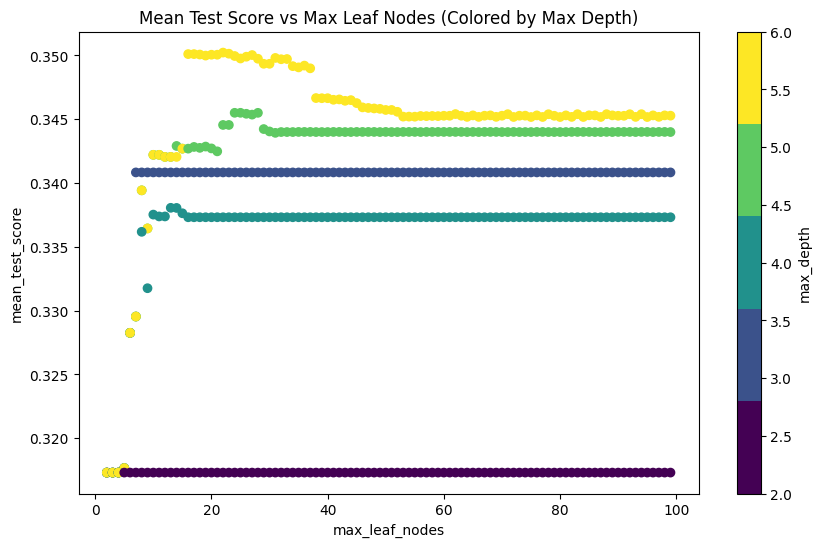

In [49]:
# Extract max_depth values from params
params['max_depth'] = params['params'].apply(lambda x: x['max_depth'])

# Plot mean_test_score vs max_leaf_nodes with color based on max_depth
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    params["params"].apply(lambda x: x["max_leaf_nodes"]),
    params["mean_test_score"],
    c=params["max_depth"],
    # quantized cmap
    cmap=plt.get_cmap('viridis', 5),
)
plt.colorbar(scatter, label='max_depth')
plt.xlabel('max_leaf_nodes')
plt.ylabel('mean_test_score')
plt.title('Mean Test Score vs Max Leaf Nodes (Colored by Max Depth)')
plt.show()

In [50]:
best_model = tree.DecisionTreeClassifier(max_depth=7, max_leaf_nodes=6, class_weight=class_weights_up_down)
best_model = best_model.fit(X_up_down, y_up_down, sample_weight=np.where(y_up_down != 4, np.ones(y_up_down.shape), 0.32))
y_pred = best_model.predict(X_up_down)
y_pred_train = best_model.predict(X_up_down)

print("Report Test")
print(classification_report(y_up_down, y_pred))
print("Report Train")
print(classification_report(y_up_down, y_pred_train))

Report Test
              precision    recall  f1-score   support

           3       0.07      0.97      0.14      3169
           4       0.00      0.00      0.00     45412
           5       0.07      0.40      0.12      1419

    accuracy                           0.07     50000
   macro avg       0.05      0.46      0.08     50000
weighted avg       0.01      0.07      0.01     50000

Report Train
              precision    recall  f1-score   support

           3       0.07      0.97      0.14      3169
           4       0.00      0.00      0.00     45412
           5       0.07      0.40      0.12      1419

    accuracy                           0.07     50000
   macro avg       0.05      0.46      0.08     50000
weighted avg       0.01      0.07      0.01     50000



/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

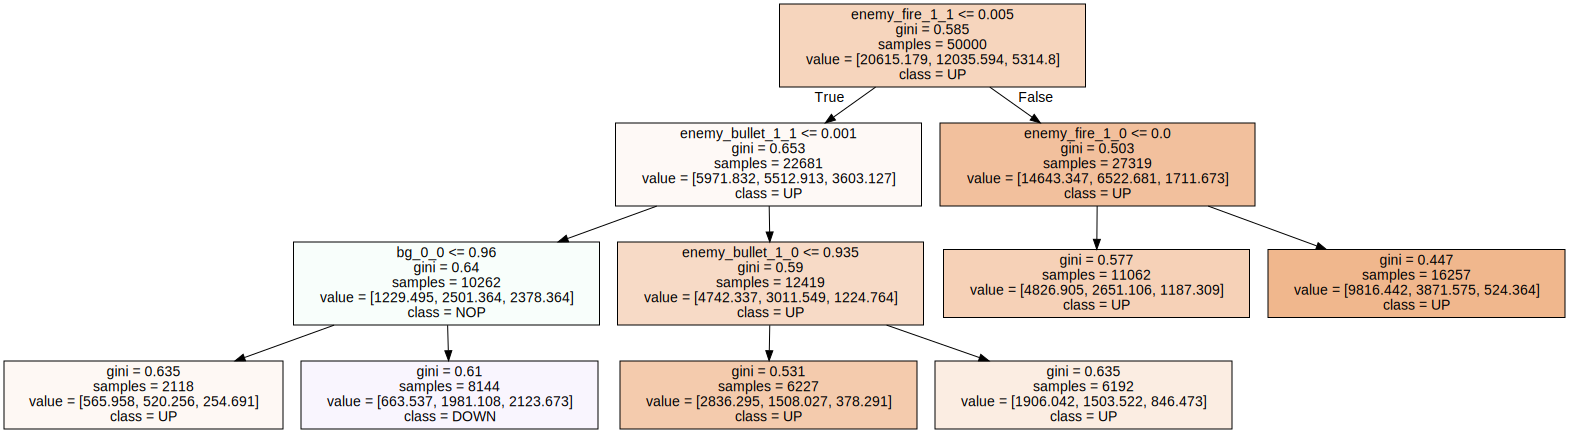

In [51]:
# plot tree
dot_data = tree.export_graphviz(best_model, out_file=None,
                                class_names=["UP","NOP", "DOWN"],
                                feature_names=features_names_all,
                                filled=True)
# Draw graph
graph = graphviz.Source(dot_data, filename=None, format="png")
graph
